In [1]:
import sys
sys.path.append("..")

# Baseline Chains

We evaluate 3 architectures, as shown here:

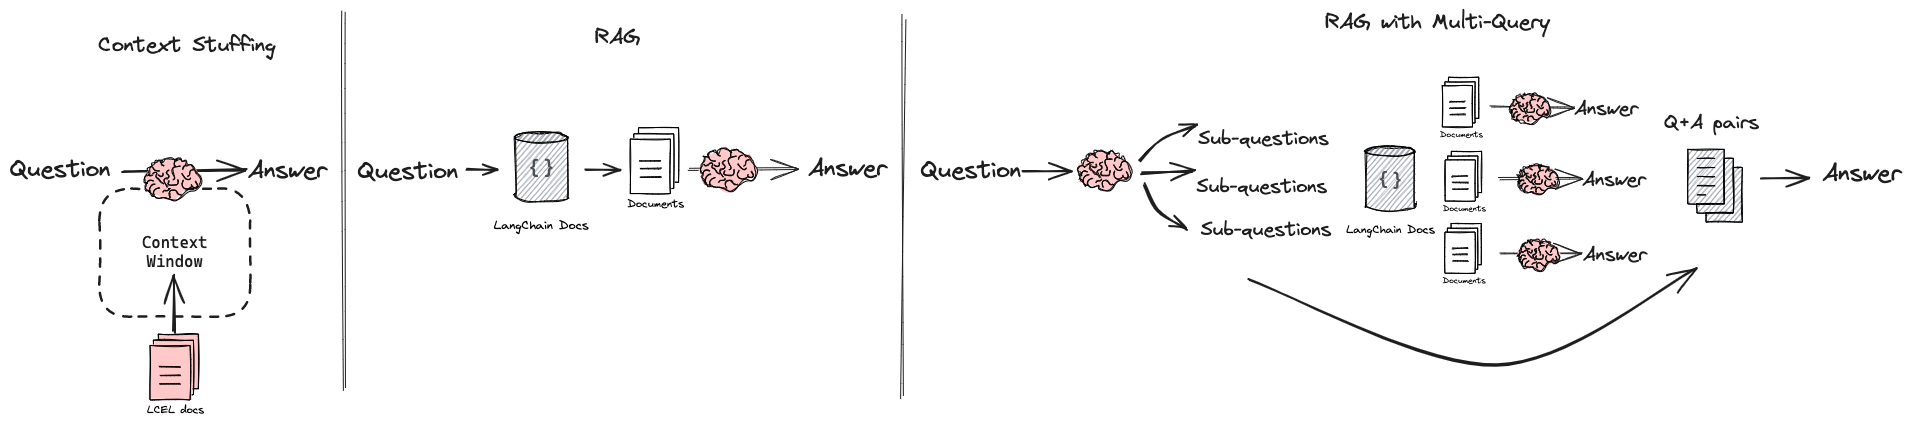

For context stuff, we try GPT-4 `128k token` models from `11-06-2023` and `01-25-2024` releases.

In [2]:
from app.base_rag_chain import chain as base_rag
from app.multi_query_chain import chain as multi_query
from app.context_stuffing_chain import chain as context_stuffing
from app.context_stuffing_0125_chain import chain as context_stuffing_0125

## LangSmith CoT Evaluator

### Evaluation

We created an eval set following the approach shown in `build_eval_set.ipynb`.

We write this to `eval.csv`. We upload the csv to LangSmith and name it `lcel-teacher-eval`.

This will use GPT-4 to perform a comparative sematic analysis between the model generated answer and ground truth.

Public evals [here](https://smith.langchain.com/public/ea1f6ca5-de52-4d36-bd7b-fde3faa74a70/d).

In [ ]:
import uuid
from langsmith.client import Client
from langchain.smith import RunEvalConfig
from langchain_core.runnables import RunnableLambda
from langchain.output_parsers import PydanticOutputParser
from langchain.pydantic_v1 import BaseModel, Field
from langchain.schema.output_parser import StrOutputParser

# Config
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    "base-case-rag":base_rag,
    "multi-query":multi_query,
    "context-stuffing": context_stuffing,
    "context-stuffing-0125": context_stuffing_0125,
}

# Run evaluation
test_runs = {}
for _ in range(2):  # Loop to run the evaluation N times
    run_id = uuid.uuid4().hex[:4]
    for project_name, chain in chain_map.items():
        
        # Pass map to chain
        if project_name == "multi-query":
            llm_or_chain_factory = chain 
            
        # Uses RunnablePassthrough, so pass question as str
        else:
            llm_or_chain_factory = lambda: (lambda x: x["question"]) | chain
            
        # Run
        test_result = client.run_on_dataset(
            dataset_name="lcel-teacher-eval",
            llm_or_chain_factory=llm_or_chain_factory,
            evaluation=eval_config,
            verbose=True,
            project_name=f"{run_id}-{project_name}",
            project_metadata={"chain": project_name},
        )

    test_runs[f"{run_id}-{project_name}"] = test_result

### Statistics

Results from [here](https://smith.langchain.com/public/ea1f6ca5-de52-4d36-bd7b-fde3faa74a70/d).

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def group_standard_error(group):
    """
    Calculate the standard error for the 'correct' column in a given group.

    The function assumes the 'correct' column contains binary values (0 or 1).
    It computes the standard error based on the formula for the standard error
    of a proportion, which is sqrt(p * (1 - p) / n), where p is the proportion
    of successes (1s) and n is the total number of trials.

    Args:
    group (pd.DataFrame): A DataFrame group with a 'correct' column.

    Returns:
    pd.Series: A series containing the standard error of the 'correct' column.
    """
    # 3 trials x 20 questions per trial = 60
    total_trials = len(group) 
    std_errors = {}
    for column in ["correct"]:
        # Number correct
        occurrences = group[column].sum()
        # Total trials
        fraction = occurrences / total_trials
        # Standard error
        std_errors[column] = (fraction * (1 - fraction) / total_trials) ** 0.5
    return pd.Series(std_errors)


# Results 
df_cot_eval = pd.read_csv("CoT_eval_result.csv")

# Minor change to naming
df_cot_eval['chain'].replace({'context-stuffing-0125': 'cs-0125', 'context-stuffing-1106': 'cs-1106'}, inplace=True)

# Stats
std_errors = df_cot_eval.groupby(["chain"]).apply(group_standard_error)
grouped_frac_correct = df_cot_eval.groupby('chain')['correct'].sum() / df_cot_eval.groupby('chain')['correct'].count() 
correct_frac_and_errors = pd.concat([grouped_frac_correct, std_errors["correct"]], axis=1)
correct_frac_and_errors.columns = ["Fraction correct", "Std error"]
correct_frac_and_errors.reset_index(inplace=True)
correct_frac_and_errors.sort_values("Fraction correct",inplace=True)

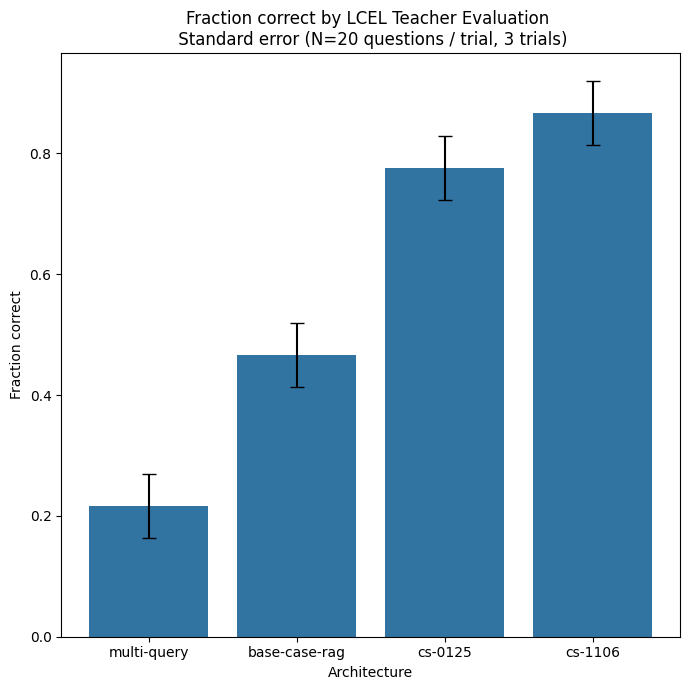

In [60]:
# Plot
def plt_bar_graph(df, field):
    """
    Plot a bar graph with error bars for the specified field in the provided DataFrame.

    The function creates a bar graph using seaborn's barplot function. Each bar represents
    a value from the specified 'field' column in the DataFrame. Error bars are added to each
    bar, representing the standard error for that value, taken from the 'Std error' column.

    The function assumes the DataFrame has the following columns:
    - 'chain': The categories for the x-axis.
    - The specified 'field' column: The values for the y-axis.
    - 'Std error': The standard errors corresponding to the values in the 'field' column.

    Args:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    field (str): The name of the column in the DataFrame to be plotted on the y-axis.

    This function does not return any value but displays the bar graph.
    """
    plt.figure(figsize=(7, 7))
    barplot = sns.barplot(
        x="chain",
        y=field,
        data=df,
        capsize=0.1,
    )

    # Find the total number of bars for each resolution group and their width
    n_bars = len(df["chain"].unique())
    bar_width = barplot.patches[0].get_width()

    # Iterate over the bars
    for i, bar in enumerate(barplot.patches):
        # Calculate the index of the standard error corresponding to the bar
        std_error_index = i // n_bars
        # Calculate the error from the 'Std error' column
        error = df["Std error"].iloc[std_error_index]
        # Plot the error bars
        barplot.errorbar(
            bar.get_x() + bar_width / 2,  # X position is the center of the bar
            bar.get_height(),  # Y position is the height of the bar
            yerr=error,  # Y error is the standard error
            fmt="none",  # No connecting lines
            color="black",  # Color of the error bars
            capsize=5,  # Width of the caps on the error bars
        )

    plt.title(f"{field} by LCEL Teacher Evaluation \n Standard error (N=20 questions / trial, 3 trials)")
    plt.xlabel("Architecture")
    plt.ylabel(field)
    plt.tight_layout()
    plt.show()

plt_bar_graph(correct_frac_and_errors, "Fraction correct")

# Structured Output Chains

We added a series of chain that produce structured output.
 
These chains use `PydanticOutputParser` to format the LLM output into a `prefix` (text preamble) and `code_block` (the code itself).

This gives us the opportunity to explicity parse the `code_block` and execute it.

In [ ]:
# Chains with parsing
from app.base_rag_chain_code_parser import chain as base_rag_code_parser
from app.multi_query_chain_code_parser import chain as multi_query_code_parser
from app.context_stuffing_chain_code_parser import chain as context_stuffing_code_parser
from app.context_stuffing_0125_chain_code_parser import chain as context_stuffing_0125_code_parser

## LangSmith CoT Evaluator

See [here](https://smith.langchain.com/public/fe14f2d3-fddf-4ac0-b354-c3cbf1147eea/d) : `02a7` prefix experiments.

In [ ]:
import uuid
from langsmith.client import Client
from langchain.smith import RunEvalConfig
from langchain_core.runnables import RunnableLambda
from langchain.output_parsers import PydanticOutputParser
from langchain.pydantic_v1 import BaseModel, Field
from langchain.schema.output_parser import StrOutputParser

# Output parser 
class FunctionOutput(BaseModel):
    prefix: str = Field(description="The prefix of the output")
    code_block: str = Field(description="The code block of the output")

parser = PydanticOutputParser(pydantic_object=FunctionOutput)

def parse_answer_to_str(x):
    """
    Creates a formatted string output for the _code_parser series of models. 
    This can be added with: | RunnableLambda(parse_answer_to_str) to the end of the chain.
 
    The parser is designed to extract a 'prefix' and a 'code_block' from the input.
    The function then concatenates these two parts, separated by a specific delimiter,
    and returns the concatenated string. If parsing fails, the function returns the input as a string.

    Parameters:
    x: Runnable with output following schema as defined in FunctionOutput above

    Returns:
    str: A string that combines the parsed 'prefix' and 'code_block', separated by a delimiter.
         If parsing fails, returns the input converted to a string.

    Note:
    - The function relies on a global 'parser' object of type PydanticOutputParser.
    - The parser is expected to parse inputs into an instance of FunctionOutput, 
      which contains 'prefix' and 'code_block' attributes.
    """
    try:
        parsed_output = parser.invoke(x)
        prefix = parsed_output.prefix
        code_block = parsed_output.code_block
        return prefix + "\n--- --- ---\n" + code_block
    except:
        return str(x)

# Config
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    "base-case-rag":base_rag_code_parser,
    "context-stuffing": context_stuffing_code_parser,
    "context-stuffing-0125": context_stuffing_0125_code_parser,
    "multi-query":multi_query_code_parser
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    
    # Pass map to chain
    if project_name == "multi-query":
        llm_or_chain_factory = chain | RunnableLambda(parse_answer_to_str)
        
    # Uses RunnablePassthrough, so pass question as str
    else:
        llm_or_chain_factory = lambda: (lambda x: x["question"]) | chain | RunnableLambda(parse_answer_to_str)
        
    # Run
    test_runs[project_name] = client.run_on_dataset(
        dataset_name="lcel-teacher-eval-v2",
        llm_or_chain_factory=llm_or_chain_factory,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{run_id}-{project_name}",
        project_metadata={"chain": project_name},
    )

## Code Execution

Test for code execution.

In [ ]:
# Read eval set
import pandas as pd
eval_set = pd.read_csv("eval.csv")

def eval_code_execution(chain,chain_name):
    """
    Evaluate the code execution for a given chain and log the results.

    This function iterates over a set of questions, invokes the specified chain
    for each question, and attempts to parse and execute the resulting code. 
    It logs the success or failure of both parsing and execution steps, along with any errors,
    in a pandas DataFrame.

    Parameters:
    chain (Runnable): The chain to be invoked for each question.
    chain_name (str): The name of the chain, used for logging purposes.

    Returns:
    pandas.DataFrame: A DataFrame containing the chain name, question, success status,
                      and any errors encountered during parsing or code execution.

    Note:
    - The function expects `eval_set` (pandas DataFrame) and `parser` (LangChain Parser object)
      to be available in its scope.
    - The `eval_set` DataFrame should have a column named 'question' containing the questions to be evaluated.
    """

    # Store
    results_df = pd.DataFrame(columns=['Chain', 'Question', 'Answer', 'Success', 'Code Error', 'Parser Error'])
    
    # Iterate through questions
    for question in list(eval_set['question']):  

        # Invoke
        answer = chain.invoke(question)

        # Parse code
        try:
            parsed_output = parser.invoke(answer)
            prefix = parsed_output.prefix
            code_block = parsed_output.code_block
            
        except Exception as e:
            print("Parse error: %s, %s"%(chain_name,question))
            temp_df = pd.DataFrame([{'Chain': chain_name, 'Question': question, 'Answer': answer, 'Success': 0, 'Parser Error': str(e)}])
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
                      
        # Execute code
        try:
            exec(code_block)
            temp_df = pd.DataFrame([{'Chain': chain_name, 'Question': question, 'Answer': answer, 'Success': 1, 'Code Error': None}])
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
            
        except Exception as e:
            print("Code error: %s, %s"%(chain_name,question))
            temp_df = pd.DataFrame([{'Chain': chain_name, 'Question': question, 'Answer': answer, 'Success': 0, 'Code Error': str(e)}])
            results_df = pd.concat([results_df, temp_df], ignore_index=True)

    return results_df

In [18]:
# Run evals for code execution
df_list=[]

for chain_name, chain in chain_map.items():
    
    if chain_name == "multi-query":
        chain = {"question": RunnablePassthrough()} | chain
    
    df=eval_code_execution(chain,chain_name)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("code_execution_eval_results.csv",index=False)